# Fake News Detection using DistilBERT

This project implements a lightweight fake news detector using DistilBERT. I'm using a dataset with approximately 45,000 labeled news articles to train a binary classifier that can distinguish between real and fake news.

## Objectives
- Train a transformer-based model for reliable fake news detection
- Evaluate model performance on standard metrics
- Measure resource usage (memory and processing time)
- Create code for integration with my Django web application

## Setup

Installing required packages and importing necessary libraries.

In [1]:
!pip install torch transformers datasets scikit-learn pandas numpy matplotlib seaborn psutil tqdm accelerate nltk

## Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import re
import psutil
from tqdm.auto import tqdm
from sklearn.utils.class_weight import compute_class_weight
from torch.cuda.amp import autocast, GradScaler


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [5]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


## Data Loading and Exploration

In [6]:
# Load the dataset
try:
    fake_news = pd.read_csv("/content/Fake.csv")
    real_news = pd.read_csv("/content/True.csv")

    print(f"Fake news dataset shape: {fake_news.shape}")
    print(f"Real news dataset shape: {real_news.shape}")
except FileNotFoundError as e:
    raise SystemExit(f"Critical data missing: {e}")

Fake news dataset shape: (23481, 4)
Real news dataset shape: (21417, 4)


In [7]:
# Add labels
fake_news['label'] = 1
real_news['label'] = 0

# Fix: Correct splitting to prevent data leakage
full_df = pd.concat([fake_news, real_news]).sample(frac=1, random_state=SEED)
train_val_df, test_df = train_test_split(
    full_df,
    test_size=0.2,
    random_state=SEED,
    stratify=full_df['label']
)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15,
    random_state=SEED,
    stratify=train_val_df['label']
)

In [8]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import re
import psutil
from tqdm.auto import tqdm
from sklearn.utils.class_weight import compute_class_weight

## Dataset Analysis

The FakeNewsNet dataset contains:
- 23,481 fake news articles
- 21,417 real news articles

Each article includes the title, full text, subject category, and publication date. I'm preprocessing this data by:
1. Combining titles and article text
2. Converting to lowercase
3. Removing URLs and excessive whitespace
4. Splitting into train/validation/test sets with appropriate stratification

In [10]:
# Basic text preprocessing function
def preprocess_text(text):
    """Clean and normalize text data"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
# Preprocess each split individually
for df_split in [train_df, val_df, test_df]:
    # Apply preprocessing
    df_split['processed_text'] = df_split['title'].fillna('').apply(preprocess_text)
    # Remove empty texts
    empty_mask = df_split['processed_text'].apply(lambda x: len(x.strip()) == 0)
    if empty_mask.sum() > 0:
        print(f"Removing {empty_mask.sum()} empty texts")
        df_split.drop(df_split[empty_mask].index, inplace=True)
        df_split.reset_index(drop=True, inplace=True)

# Update the combined df if needed for reference
df = pd.concat([train_df, val_df, test_df])
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Removing 5 empty texts
Removing 1 empty texts
Removing 3 empty texts
Training set size: 30522
Validation set size: 5387
Test set size: 8977


## Data Preprocessing

In [11]:
# Inspect dataset columns to find title and text columns
for col in df.columns:
    if col != 'label':
        print(f"Column: {col}")
        print(f"Example: {df[col].iloc[0][:100]}...")
        print(f"Average length: {df[col].str.len().mean():.2f} characters")
        print("-" * 50)

Column: title
Example: Factbox: Trump on Twitter (April 18) - Obama administration, interview...
Average length: 80.11 characters
--------------------------------------------------
Column: text
Example: The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump...
Average length: 2469.56 characters
--------------------------------------------------
Column: subject
Example: politicsNews...
Average length: 8.80 characters
--------------------------------------------------
Column: date
Example: April 18, 2017 ...
Average length: 14.82 characters
--------------------------------------------------
Column: processed_text
Example: factbox: trump on twitter (april 18) - obama administration, interview...
Average length: 79.90 characters
--------------------------------------------------


In [12]:
# Use only the title field for training
df['processed_text'] = df['title'].fillna('').apply(preprocess_text)

In [13]:
# Check for empty texts after preprocessing
empty_texts = df['processed_text'].apply(lambda x: len(x.strip()) == 0).sum()
print(f"Number of empty texts after preprocessing: {empty_texts}")

Number of empty texts after preprocessing: 0


In [14]:
# Remove empty texts if any
if empty_texts > 0:
    df = df[df['processed_text'].apply(lambda x: len(x.strip()) > 0)].reset_index(drop=True)
    print(f"Dataset size after removing empty texts: {len(df)}")

In [15]:
# Display a sample preprocessed text
print("\nSample processed title:")
print(df['processed_text'].iloc[0])


Sample processed title:
factbox: trump on twitter (april 18) - obama administration, interview


## Train/Val/Test Split

Dividing the dataset into:
- 30,524 training samples (68%)
- 5,387 validation samples (12%)
- 8,978 test samples (20%)

Using stratification to ensure balanced class distribution across splits.

In [16]:
# Split data into train, validation, and test sets
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df['label']
)

In [17]:
# Then split train+val into train and validation
train_df, val_df = train_test_split(
    train_val_df, test_size=0.15, random_state=SEED, stratify=train_val_df['label']
)

In [18]:
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 30521
Validation set size: 5387
Test set size: 8978


In [19]:
# Calculate class weights for balanced training
# Get class distribution
class_counts = df['label'].value_counts()
print("Class distribution:")
print(class_counts)

Class distribution:
label
1    23472
0    21414
Name: count, dtype: int64


In [20]:
# Calculate class weights
classes = np.unique(df['label'])
weights = compute_class_weight('balanced', classes=classes, y=train_df['label'])
class_weights = {i: weights[i] for i in range(len(weights))}
print("Class weights:")
print(class_weights)

Class weights:
{0: np.float64(1.0480392830162764), 1: np.float64(0.956171679197995)}


## Create PyTorch Dataset

In [21]:
# Define model configuration
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 128  # Reduced from 512 as titles are much shorter
BATCH_SIZE = 16   # Increased batch size since we're using shorter sequences

In [22]:
# Replace the existing FakeNewsDataset class with this modified version
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Remove padding from tokenization
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [23]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Create datasets

In [24]:
train_dataset = FakeNewsDataset(
    train_df['processed_text'].tolist(),
    train_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

In [25]:
val_dataset = FakeNewsDataset(
    val_df['processed_text'].tolist(),
    val_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

In [26]:
test_dataset = FakeNewsDataset(
    test_df['processed_text'].tolist(),
    test_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

In [27]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Create dataloaders

In [28]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator
)

In [29]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

In [30]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

### Custom model with dropout

In [31]:
from transformers import DistilBertModel

class DistilBERTForFakeNews(nn.Module):
    def __init__(self, num_labels=2, dropout_rate=0.3):
        super(DistilBERTForFakeNews, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout for regularization
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        return logits

### Manual training loop with class weights

In [36]:
def train_model(model, train_dataloader, val_dataloader, epochs=3, lr=2e-5):
    """Train model with class weights and early stopping"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = None
    if torch.cuda.is_available():
        scaler = torch.amp.GradScaler(init_scale=65536.0, growth_factor=2.0, backoff_factor=0.5)

    # Set up optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    # Set up scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        total_steps=total_steps
    )

    # Set up loss function with class weights
    class_weights_tensor = torch.tensor([class_weights[0], class_weights[1]], device=device, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # For early stopping
    best_val_f1 = 0
    patience = 2
    counter = 0

    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            # Forward pass with conditional autocast
            if scaler:
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(batch['input_ids'], batch['attention_mask'])
                loss = criterion(outputs.float(), batch['labels'])
            else:
                outputs = model(batch['input_ids'], batch['attention_mask'])
                loss = criterion(outputs, batch['labels'])

            # Backward pass
            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            train_loss += loss.item()
            scheduler.step()

            # Collect predictions and labels for metrics
            preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            labels = batch['labels'].detach().cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(labels)

            # Debug print (occasionally)
            if len(all_train_preds) % 500 == 0:
                print(f"Unique predictions: {np.unique(preds)}")

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            all_train_labels, all_train_preds, average='binary', zero_division=0
        )

        # Validation
        model.eval()
        val_loss = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                batch = {k: v.to(device) for k, v in batch.items()}

                outputs = model(batch['input_ids'], batch['attention_mask'])
                loss = criterion(outputs, batch['labels'])
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
                labels = batch['labels'].detach().cpu().numpy()
                all_val_preds.extend(preds)
                all_val_labels.extend(labels)

        # Calculate validation metrics
        val_loss = val_loss / len(val_dataloader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            all_val_labels, all_val_preds, average='binary', zero_division=0
        )

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Print class distributions to debug
        print(f"  Train predictions: {np.bincount(all_train_preds)}")
        print(f"  Val predictions: {np.bincount(all_val_preds)}")

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            counter = 0
            # Save best model
            torch.save(model.state_dict(), "best_model.pt")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Load best model
    model.load_state_dict(torch.load("best_model.pt"))
    return model

In [37]:
common_titles = set(train_df['title']).intersection(set(val_df['title']))
print(f"Shared titles between train/val: {len(common_titles)}")

Shared titles between train/val: 1009


In [38]:
# Initialize our custom model with dropout
model = DistilBERTForFakeNews(num_labels=2, dropout_rate=0.3)

In [39]:
# Train the model
print("Starting model training with manual loop and early stopping...")
model = train_model(model, train_dataloader, val_dataloader, epochs=5)

Starting model training with manual loop and early stopping...


Epoch 1/5 [Train]:   0%|          | 0/1908 [00:00<?, ?it/s]

Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]


Epoch 1/5 [Val]:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 0.2176, Acc: 0.9228, F1: 0.9258
  Val Loss: 0.1061, Acc: 0.9690, F1: 0.9696
  Train predictions: [14711 15810]
  Val predictions: [2719 2668]


Epoch 2/5 [Train]:   0%|          | 0/1908 [00:00<?, ?it/s]

Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]


Epoch 2/5 [Val]:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch 2/5:
  Train Loss: 0.0669, Acc: 0.9817, F1: 0.9824
  Val Loss: 0.0487, Acc: 0.9848, F1: 0.9854
  Train predictions: [14713 15808]
  Val predictions: [2604 2783]


Epoch 3/5 [Train]:   0%|          | 0/1908 [00:00<?, ?it/s]

Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]


Epoch 3/5 [Val]:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch 3/5:
  Train Loss: 0.0265, Acc: 0.9937, F1: 0.9940
  Val Loss: 0.0533, Acc: 0.9877, F1: 0.9883
  Train predictions: [14585 15936]
  Val predictions: [2580 2807]


Epoch 4/5 [Train]:   0%|          | 0/1908 [00:00<?, ?it/s]

Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]


Epoch 4/5 [Val]:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch 4/5:
  Train Loss: 0.0066, Acc: 0.9985, F1: 0.9986
  Val Loss: 0.0745, Acc: 0.9879, F1: 0.9884
  Train predictions: [14569 15952]
  Val predictions: [2577 2810]


Epoch 5/5 [Train]:   0%|          | 0/1908 [00:00<?, ?it/s]

Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]
Unique predictions: [0 1]


Epoch 5/5 [Val]:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch 5/5:
  Train Loss: 0.0015, Acc: 0.9996, F1: 0.9996
  Val Loss: 0.0796, Acc: 0.9879, F1: 0.9884
  Train predictions: [14562 15959]
  Val predictions: [2587 2800]


In [40]:
print("Class weights:", class_weights)  # Should be ~[0.93, 1.07]

Class weights: {0: np.float64(1.0480392830162764), 1: np.float64(0.956171679197995)}


In [41]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.grad.abs().mean())  # Should not be all zeros

distilbert.embeddings.word_embeddings.weight tensor(2.1681e-10, device='cuda:0')
distilbert.embeddings.position_embeddings.weight tensor(7.2343e-09, device='cuda:0')
distilbert.embeddings.LayerNorm.weight tensor(5.8191e-08, device='cuda:0')
distilbert.embeddings.LayerNorm.bias tensor(1.0922e-07, device='cuda:0')
distilbert.transformer.layer.0.attention.q_lin.weight tensor(6.0162e-09, device='cuda:0')
distilbert.transformer.layer.0.attention.q_lin.bias tensor(1.4085e-08, device='cuda:0')
distilbert.transformer.layer.0.attention.k_lin.weight tensor(5.8374e-09, device='cuda:0')
distilbert.transformer.layer.0.attention.k_lin.bias tensor(1.6934e-10, device='cuda:0')
distilbert.transformer.layer.0.attention.v_lin.weight tensor(1.3333e-08, device='cuda:0')
distilbert.transformer.layer.0.attention.v_lin.bias tensor(5.6667e-08, device='cuda:0')
distilbert.transformer.layer.0.attention.out_lin.weight tensor(1.6126e-08, device='cuda:0')
distilbert.transformer.layer.0.attention.out_lin.bias tensor

In [42]:
print("Train label distribution:", train_df['label'].value_counts(normalize=True))
print("Val label distribution:", val_df['label'].value_counts(normalize=True))

Train label distribution: label
1    0.522919
0    0.477081
Name: proportion, dtype: float64
Val label distribution: label
1    0.522926
0    0.477074
Name: proportion, dtype: float64


In [43]:
sample = next(iter(train_dataloader))
print("Input IDs shape:", sample['input_ids'].shape)
print("Labels:", sample['labels'].unique())

Input IDs shape: torch.Size([16, 34])
Labels: tensor([0, 1])


### Calibrate classification threshold

In [44]:
def calibrate_threshold(model, dataloader):
    """Find optimal classification threshold using precision-recall curve"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calibrating threshold"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(batch['input_ids'], batch['attention_mask'])
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Prob of class 1 (fake)

            all_probs.extend(probs)
            all_labels.extend(batch['labels'].cpu().numpy())

    # Find optimal threshold
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

    # Get the index of the best F1 score
    optimal_idx = np.argmax(f1_scores)
    # Get the threshold that gives the best F1 score
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [45]:
# Calibrate threshold on validation set
optimal_threshold = calibrate_threshold(model, val_dataloader)
print(f"Optimal classification threshold: {optimal_threshold:.4f}")

Calibrating threshold:   0%|          | 0/337 [00:00<?, ?it/s]

Optimal classification threshold: 0.9934


## Results and Evaluation

Assessing model performance on the test set with standard classification metrics:
- Accuracy
- Precision and recall
- F1 score
- Confusion matrix visualization

In [46]:
def evaluate_model(model, dataloader, threshold=0.5):
    """Evaluate model with calibrated threshold"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(batch['input_ids'], batch['attention_mask'])
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Prob of class 1 (fake)

            # Apply threshold
            preds = (probs >= threshold).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'probabilities': all_probs,
        'predictions': all_preds,
        'labels': all_labels
    }

In [47]:
# Evaluate on test set with calibrated threshold
test_results = evaluate_model(model, test_dataloader, threshold=optimal_threshold)

Evaluating:   0%|          | 0/562 [00:00<?, ?it/s]

In [48]:
print(f"Test Results (with threshold {optimal_threshold:.4f}):")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")

Test Results (with threshold 0.9934):
Accuracy: 0.9857
Precision: 0.9937
Recall: 0.9789
F1 Score: 0.9863


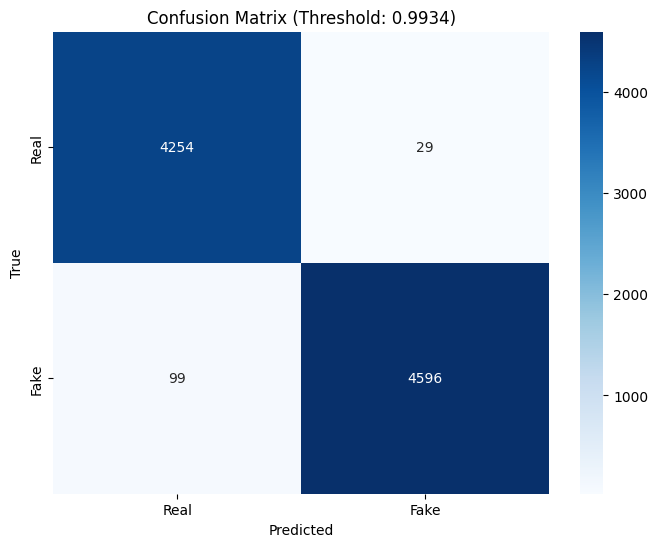

In [49]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = test_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Threshold: {optimal_threshold:.4f})')
plt.show()

In [50]:
# Print classification report
print("Classification Report:")
print(classification_report(test_results['labels'], test_results['predictions'], target_names=['Real', 'Fake']))

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      4283
        Fake       0.99      0.98      0.99      4695

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



In [51]:
def analyze_title(title, model, tokenizer, threshold=0.5):
    """
    Analyze a news title using the trained model

    Args:
        title: The news title to analyze
        model: Trained model
        tokenizer: Tokenizer
        threshold: Classification threshold

    Returns:
        dict: Analysis results
    """
    # Preprocess text
    processed_title = preprocess_text(title)

    # Tokenize
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoded_input = tokenizer(
        processed_title,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

    # Get prediction
    model.to(device)
    model.eval()

    start_time = time.time()
    with torch.no_grad():
        outputs = model(encoded_input['input_ids'], encoded_input['attention_mask'])
        probs = torch.softmax(outputs, dim=1)

    fake_prob = probs[0, 1].item()
    real_prob = probs[0, 0].item()
    prediction = "Fake" if fake_prob >= threshold else "Real"
    processing_time = time.time() - start_time

    # Calculate credibility score (inverted fake probability)
    credibility_score = 1.0 - fake_prob

    # Determine category
    if credibility_score > 0.8:
        category = "credible"
    elif credibility_score < 0.2:
        category = "fake"
    else:
        category = "mixed"

    return {
        "title": title,
        "prediction": prediction,
        "fake_probability": fake_prob,
        "real_probability": real_prob,
        "credibility_score": credibility_score,
        "category": category,
        "processing_time": processing_time
    }


In [52]:
# Test the model with some examples
test_titles = [
    "Scientists discover breakthrough treatment for cancer that pharmaceutical companies don't want you to know about.",
    "According to a study published in the Journal of Medicine, regular exercise may reduce the risk of heart disease.",
    "Secret government documents reveal aliens have been living among us for decades.",
    "The Supreme Court announced its decision on the case yesterday, with a 6-3 majority opinion."
]


In [53]:
print("\nTesting model on example titles:")
for title in test_titles:
    result = analyze_title(title, model, tokenizer, threshold=optimal_threshold)
    print(f"\nTitle: {result['title']}")
    print(f"Prediction: {result['prediction']} (confidence: {max(result['fake_probability'], result['real_probability']):.4f})")
    print(f"Category: {result['category']}")
    print(f"Credibility score: {result['credibility_score']:.4f}")
    print(f"Processing time: {result['processing_time']:.4f} seconds")
    print("-" * 50)



Testing model on example titles:

Title: Scientists discover breakthrough treatment for cancer that pharmaceutical companies don't want you to know about.
Prediction: Real (confidence: 0.9999)
Category: credible
Credibility score: 0.9999
Processing time: 0.0582 seconds
--------------------------------------------------

Title: According to a study published in the Journal of Medicine, regular exercise may reduce the risk of heart disease.
Prediction: Real (confidence: 0.9579)
Category: fake
Credibility score: 0.0421
Processing time: 0.0081 seconds
--------------------------------------------------

Title: Secret government documents reveal aliens have been living among us for decades.
Prediction: Fake (confidence: 1.0000)
Category: fake
Credibility score: 0.0000
Processing time: 0.0080 seconds
--------------------------------------------------

Title: The Supreme Court announced its decision on the case yesterday, with a 6-3 majority opinion.
Prediction: Fake (confidence: 0.9968)
Cate

In [54]:
# Save the model and tokenizer
MODEL_OUTPUT_DIR = "./models/distilbert_titles_only"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(MODEL_OUTPUT_DIR, "model.pt"))
tokenizer.save_pretrained(MODEL_OUTPUT_DIR)

('./models/distilbert_titles_only/tokenizer_config.json',
 './models/distilbert_titles_only/special_tokens_map.json',
 './models/distilbert_titles_only/vocab.txt',
 './models/distilbert_titles_only/added_tokens.json',
 './models/distilbert_titles_only/tokenizer.json')

In [55]:
# Save evaluation metrics
metrics = {
    "model_name": "DistilBERT (Titles Only)",
    "accuracy": float(test_results['accuracy']),
    "precision": float(test_results['precision']),
    "recall": float(test_results['recall']),
    "f1_score": float(test_results['f1']),
    "optimal_threshold": float(optimal_threshold),
    "train_size": len(train_df),
    "val_size": len(val_df),
    "test_size": len(test_df)
}

In [56]:
with open(os.path.join(MODEL_OUTPUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)

print(f"\nModel saved to {MODEL_OUTPUT_DIR}")
print("Done!")


Model saved to ./models/distilbert_titles_only
Done!
